# Market States approach

- From the observations that with tabular models (gradient boosting ensemble),
shuffling the data guarantees no overfitting 
while splitting with chronological order overfits / does not capture the test probability distribution, 
it seems like a time-series approach is necessary :
timestamps are not independant draws of one underlying random variable.
- Defining some latent state of the time-series is expected to be an improvement,
- Also possible to cluster the timesteps into market modes, then to fit a predictor for each market mode.
- Market modes can be defined from the covariance matrix of the features
- Covariance matrix filtering techniques to reduce noise 

In [1]:
import os
import numpy as np
import pandas as pd
import polars as pl
from typing import List
from pathlib import Path
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

for dirname, _, filenames in os.walk("/kaggle/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

KAGGLE = False  # define paths accordingly
SUBMISSION = False  # use smaller datasets during dev

if KAGGLE:
    crypto_folder = Path("/kaggle/input/drw-crypto-market-prediction")
else:
    crypto_folder = Path("../raw_data/crypto")

## Helper functions

In [2]:
def get_clean_crypto_data(train: bool = True) -> pl.LazyFrame:
    """
    Load and clean crypto data, returning either train or test set.

    Args:
        train: If True, return training set. If False, return test set.

    Returns:
        Cleaned lazy frame with columns that have variance and no infinite values.
    """

    filename = "train.parquet" if train else "test.parquet"

    # load data
    crypto_lazy = pl.scan_parquet(crypto_folder / filename)
    n_cols = len(crypto_lazy.collect_schema().names())

    if train and KAGGLE:
        # rename timestamp column
        crypto_lazy = crypto_lazy.with_columns(
            pl.col("__index_level_0__").alias("timestamp")
        ).drop(["__index_level_0__"])

    # Remove columns with zero variance in the training set
    train_lazy = pl.scan_parquet(crypto_folder / "train.parquet")
    if KAGGLE:
        train_lazy = train_lazy.with_columns(
            pl.col("__index_level_0__").alias("timestamp")
        ).drop(["__index_level_0__"])

    # Get column names and calculate variance on training set (for consistency)
    crypto_var = train_lazy.select(pl.exclude(["timestamp"]).var())

    crypto_var_cols = (
        crypto_var.select(pl.all() == 0.0)
        .first()
        .collect()
        .to_pandas()
        .T.rename(columns={0: "is_variance_null"})
        .reset_index()
        .rename(columns={"index": "column_name"})
        .groupby("is_variance_null")["column_name"]
        .unique()
    )

    crypto_cols_with_var = crypto_var_cols[False]

    try:
        cols_no_var = crypto_var_cols[True]
        print(f"Columns with no variance : {cols_no_var}")
    except KeyError:
        print("All columns have variance in the train set")

    # remove columns that have no variance in the training set
    train_lazy = train_lazy.select(
        ["timestamp"] + [pl.col(c) for c in crypto_cols_with_var]
    )

    # Remove columns with infinite values (check on training set)
    current_columns = train_lazy.collect_schema().names()
    contains_infinite_cols = (
        train_lazy.select(pl.exclude("timestamp").abs().max().is_infinite())
        .collect()
        .to_pandas()
        .T.rename(columns={0: "contains_infinite"})
        .reset_index()
        .rename(columns={"index": "column_name"})
        .groupby("contains_infinite")["column_name"]
        .unique()
    )

    try:
        cols_with_inf_vals = contains_infinite_cols[True]
        print(f"Columns with infinite values : {cols_with_inf_vals}")
    except KeyError:
        print("No columns with infinite values")

    if not train:
        # add dummy timestamps
        crypto_lazy = crypto_lazy.with_columns(
            ID=range(1, crypto_lazy.select(pl.len()).collect().item() + 1)
        )
    # Filter clean columns based on what's available in the current dataset
    clean_columns = [
        c for c in current_columns if c in contains_infinite_cols[False]
    ] + ["timestamp", "ID"]
    available_columns = crypto_lazy.collect_schema().names()
    final_columns = [c for c in clean_columns if c in available_columns]
    print(f"Eventually {len(final_columns)}, removed {n_cols - len(final_columns)}")

    return crypto_lazy.select(final_columns)


def get_diff_features(df: pl.LazyFrame, stats_columns: List[str]):
    return (
        df.with_columns(pl.exclude(stats_columns).diff())
        .with_row_index()
        .fill_null(strategy="backward")
        .select(pl.exclude("index"))
    )


def get_ma_features(df: pl.LazyFrame, cols: List[str]):
    return df.with_columns(pl.col(cols).rolling_mean(window_size=23, min_samples=1))


def get_rolling_var(df: pl.LazyFrame, cols: List[str]):
    return df.with_columns(pl.col(cols).rolling_var(window_size=23, min_samples=1))

## Metadata

In [4]:
stats_columns = [
    "timestamp",
    "bid_qty",
    "ask_qty",
    "buy_qty",
    "sell_qty",
    "volume",
    "label",
]
stats_columns_test = [
    "ID",
    "bid_qty",
    "ask_qty",
    "buy_qty",
    "sell_qty",
    "volume",
    "label",
]
X_exclude = ["timestamp", "label"]
X_test_exclude = ["ID", "label"]

## Load data

In [8]:
# create intermediate clean file
crypto_lazy_clean = get_clean_crypto_data(train=True)

Columns with no variance : ['X864' 'X867' 'X869' 'X870' 'X871' 'X872']
Columns with infinite values : ['X697' 'X698' 'X699' 'X700' 'X701' 'X702' 'X703' 'X704' 'X705' 'X706'
 'X707' 'X708' 'X709' 'X710' 'X711' 'X712' 'X713' 'X714' 'X715' 'X716'
 'X717']
Eventually 870, removed 27


In [9]:
# transform the dataset to day columns and only X features

crypto_df = crypto_lazy_clean.select(pl.exclude(stats_columns)).collect().to_pandas().T
crypto_df.to_parquet("features.parquet")
del crypto_df

In [20]:
features_lazy.collect_schema().names()[-10:]

['525878',
 '525879',
 '525880',
 '525881',
 '525882',
 '525883',
 '525884',
 '525885',
 '525886',
 '__index_level_0__']

In [16]:
features_lazy.collect_schema().names()[:10]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [7]:
features_lazy = pl.scan_parquet("features.parquet").drop("__index_level_0__")
cols = features_lazy.collect_schema().names()
features_lazy = features_lazy.select(pl.col(cols[:1000]))
n = len(features_lazy.collect_schema().names())
lazy_cor = pl.concat(
    [
        features_lazy.select(pl.corr(pl.all(), pl.col(f"{i}"))).collect()
        for i in range(n)
    ]
)
lazy_cor

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,…,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,0.853176,0.744728,0.824992,0.797097,0.814193,0.743647,0.627196,0.578635,0.758636,0.532042,0.728936,0.823151,0.832906,0.777549,0.687225,0.716489,0.773195,0.757653,0.711555,0.762342,0.756749,0.765367,0.725226,0.635637,0.726486,0.552151,0.736694,0.69096,0.613674,0.615818,0.778944,0.751962,0.759682,0.729877,0.737666,0.689867,…,0.228129,0.317515,0.165896,0.266713,0.257476,0.274642,0.139671,0.154131,0.132431,0.268789,0.129048,0.380589,0.397768,0.258073,0.290955,0.3686,0.463423,0.380521,0.292885,0.496165,0.442772,0.470479,0.470728,0.441934,0.437816,0.376972,0.239638,0.398158,0.482634,0.435666,0.37597,0.397436,0.3635,0.334791,0.413491,0.280127,0.316153
0.853176,1.0,0.951233,0.930107,0.945403,0.824902,0.769246,0.696277,0.662138,0.815326,0.675829,0.761407,0.851873,0.83173,0.899682,0.816309,0.824553,0.816872,0.755299,0.655779,0.72592,0.731722,0.731542,0.761338,0.721203,0.7126,0.679327,0.749511,0.732046,0.635743,0.643293,0.717085,0.713848,0.764417,0.711062,0.724512,0.703223,…,0.292143,0.317909,0.225211,0.249897,0.255201,0.25828,0.160221,0.164157,0.149557,0.213309,0.158419,0.285078,0.339157,0.274421,0.277672,0.306497,0.392492,0.385302,0.320107,0.420293,0.437763,0.48029,0.480207,0.494485,0.499354,0.475521,0.366194,0.440223,0.488203,0.494342,0.469933,0.460861,0.441507,0.43008,0.4577,0.413722,0.414678
0.744728,0.951233,1.0,0.885295,0.913834,0.730424,0.715521,0.697212,0.711475,0.824565,0.746694,0.770658,0.828365,0.745837,0.858635,0.805669,0.808545,0.762995,0.689543,0.589834,0.658963,0.678074,0.663824,0.718132,0.738562,0.668738,0.730315,0.728454,0.729777,0.654262,0.667277,0.671802,0.662191,0.717769,0.675148,0.693562,0.69322,…,0.330417,0.313336,0.273552,0.252896,0.259355,0.256119,0.206297,0.214816,0.204703,0.221733,0.224467,0.249837,0.29738,0.29079,0.286477,0.276356,0.325572,0.356343,0.332503,0.346232,0.398776,0.421639,0.430238,0.466135,0.475368,0.481895,0.428104,0.448986,0.452033,0.471536,0.484863,0.46678,0.445785,0.453592,0.445376,0.460525,0.452459
0.824992,0.930107,0.885295,1.0,0.969308,0.899132,0.761625,0.62481,0.560762,0.784206,0.557872,0.70607,0.833515,0.925534,0.936797,0.823918,0.848637,0.84233,0.778495,0.647239,0.739853,0.728888,0.762687,0.771891,0.697383,0.780113,0.618523,0.776944,0.709506,0.574269,0.577238,0.733178,0.737496,0.778113,0.705795,0.704023,0.663931,…,0.237845,0.30885,0.13755,0.216732,0.203885,0.216402,0.067543,0.073619,0.049897,0.158684,0.038657,0.265359,0.304601,0.160569,0.187252,0.249711,0.373299,0.295946,0.209077,0.414174,0.378975,0.448304,0.454119,0.456282,0.488995,0.430923,0.25639,0.392025,0.497157,0.485056,0.425602,0.435834,0.421473,0.394904,0.464484,0.350725,0.375521
0.797097,0.945403,0.913834,0.969308,1.0,0.893884,0.834023,0.741269,0.661703,0.805149,0.637623,0.722535,0.821589,0.862765,0.940834,0.863387,0.871263,0.865375,0.815209,0.713752,0.787154,0.786319,0.794971,0.826595,0.784055,0.787006,0.717367,0.791257,0.76585,0.658564,0.643455,0.721398,0.738455,0.794879,0.74431,0.753238,0.722568,…,0.270327,0.310288,0.201765,0.228587,0.230827,0.236146,0.135575,0.118239,0.08987,0.145998,0.088423,0.209503,0.283213,0.207049,0.205551,0.240836,0.333393,0.321165,0.259872,0.36414,0.386456,0.435638,0.451302,0.467968,0.481156,0.460523,0.33972,0.403768,0.460896,0.478361,0.466908,0.45428,0.433145,0.427385,0.464824,0.410122,0.413027
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.3635,0.441507,0

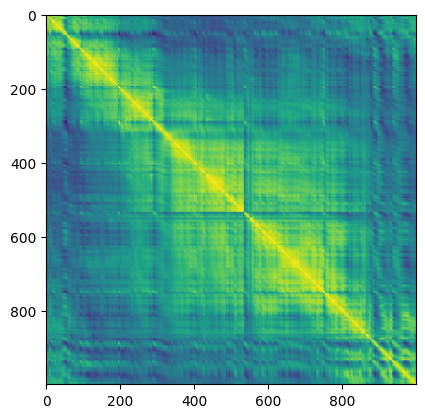

In [8]:
from matplotlib import pyplot as plt

plt.imshow(lazy_cor.to_numpy())

In [9]:
adjacency = 1.0 - lazy_cor.to_numpy()

adjacency

array([[0.        , 0.14682444, 0.25527248, ..., 0.5865086 , 0.71987268,
        0.68384697],
       [0.14682444, 0.        , 0.04876749, ..., 0.5423    , 0.58627844,
        0.58532195],
       [0.25527248, 0.04876749, 0.        , ..., 0.55462421, 0.53947519,
        0.54754132],
       ...,
       [0.5865086 , 0.5423    , 0.55462421, ..., 0.        , 0.0971836 ,
        0.08103916],
       [0.71987268, 0.58627844, 0.53947519, ..., 0.0971836 , 0.        ,
        0.02879222],
       [0.68384697, 0.58532195, 0.54754132, ..., 0.08103916, 0.02879222,
        0.        ]], shape=(1000, 1000))

In [10]:
np.save("adjancency_matrix.npy", adjacency)

In [ ]:
crypto_lazy_clean.sink_parquet("crypto_clean.parquet")

In [6]:
crypto = pd.read_parquet("crypto_clean.parquet")
cols = crypto.columns

## Filter covariance matrix between features

In [ ]:
n_samples = 50_000
cov = crypto[[c for c in cols if c not in stats_columns]].sample(n_samples).cov()
from matplotlib import pyplot as plt

plt.imshow(cov)

In [ ]:
cor = crypto[[c for c in cols if c not in stats_columns]].sample(n_samples).corr()
plt.imshow(cor)

In [ ]:
svd = np.linalg.svd(cov.values, hermitian=True)
U, S = svd.U, svd.S

In [ ]:
_, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(len(S)), S)
ax.set_yscale("log")
ax.axhline(0.1, c="red", linestyle="--")
ax.grid()

In [ ]:
cov_clean = U @ np.diag(np.where(S > 1.0, S, np.zeros_like(S))) @ U.T

plt.imshow(cov_clean)

## Compute day-wise covariance matrix to cluster timestamps into market modes

In [7]:
cor_days = crypto.T.corr()

: 

In [ ]:
adjacency = None
position = None

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(cor_days)

### Compute Louvain network communities and plot graph

In [ ]:
from IPython.display import SVG
from sknetwork.data import karate_club, painters, movie_actor
from sknetwork.clustering import Louvain, get_modularity
from sknetwork.linalg import normalize
from sknetwork.utils import get_membership
from sknetwork.visualization import visualize_graph, visualize_bigraph

louvain = Louvain()
labels = louvain.fit_predict(adjacency)
labels_unique, counts = np.unique(labels, return_counts=True)
print(labels_unique, counts)

image = visualize_graph(adjacency, position, labels=labels)
SVG(image)

## Compute adjacency matrix

## Apply Louvain clustering algorithm of community detection

In [ ]:
X = crypto_lazy_clean.select(pl.exclude(X_exclude)).collect().to_numpy()
y = crypto_lazy_clean.select(pl.col("label")).collect().to_numpy().T[0]

if not SUBMISSION:
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        shuffle=False,  # TODO : question this, whether timestamps are independant draws
        random_state=42,
    )
else:
    X_train, y_train = X, y
del X
del y

## Train model

In [ ]:
lr = 1.0

lin = RandomForestRegressor(
    # fit_intercept=True,
    n_estimators=80,
    n_jobs=-1,
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    max_features="sqrt",
    max_samples=0.5,
    random_state=41,
)
# n_samples = 80_000
lin.fit(
    X_train,
    y_train,
    # sample_weight=np.flip(1.0 / np.sqrt(np.arange(1, n_samples+1)))
)

y_train_lin = lin.predict(X_train)

print(f"R2 train lin: {r2_score(y_train, y_train_lin)}")
print(f"Pearson train lin : {pearsonr(y_train, y_train_lin)}")

y_train_res = y_train - lr * y_train_lin


lgb_model = lgb.LGBMRegressor(
    random_state=42,
    # weight=np.flip(1.0 / np.sqrt(np.arange(1, len(X_train)+1))),
    # n_estimators=80,
    # max_depth=10,
    n_jobs=-1,
)
lgb_model.fit(X_train, y_train_res)

y_train_hat = lgb_model.predict(X_train)

print(f"R2 train : {r2_score(y_train, y_train_hat + lr * y_train_lin)}")
print(f"Pearson train : {pearsonr(y_train, y_train_hat + lr * y_train_lin)}")

if not SUBMISSION:
    y_test_lin = lin.predict(X_test)

    print(f"R2 test lin : {r2_score(y_test, y_test_lin)}")
    print(f"Pearson test lin : {pearsonr(y_test, y_test_lin)}")

    y_test_hat = lgb_model.predict(X_test)

    print(f"R2 test : {r2_score(y_test, y_test_hat + lr * y_test_lin)}")
    print(f"Pearson test : {pearsonr(y_test, y_test_hat + lr * y_test_lin)}")

## Load test data

In [ ]:
crypto_lazy_test = get_clean_crypto_data(train=False)

# create unique row identifier
n = crypto_lazy_test.select(pl.len()).collect().item()
crypto_lazy_test = crypto_lazy_test.with_columns(ID=range(1, n + 1))

print(crypto_lazy_test.select(pl.len()).collect().item())

crypto_lazy_test = crypto_lazy_test.join(
    get_diff_features(crypto_lazy_test, stats_columns_test),
    on=stats_columns_test,
    how="inner",
    suffix="_diff",
)

# crypto_lazy_test = get_diff_features(crypto_lazy_test, stats_columns_test)
assert n == crypto_lazy_test.select(pl.len()).collect().item()

## Predict target \& submit

In [ ]:
X_test = crypto_lazy_test.select(pl.exclude(X_test_exclude)).collect().to_numpy()
y_lin_test = lin.predict(X_test)
y_hat_lgb_test = lgb_model.predict(X_test)

del X_test

In [ ]:
crypto_lazy_test = crypto_lazy_test.with_columns(
    ID=range(1, n + 1), prediction=y_hat_lgb_test + lr * y_lin_test
)
crypto_lazy_test.head(5).collect()
crypto_lazy_test.select([pl.col("ID"), pl.col("prediction")]).collect().write_csv(
    Path("submission.csv")
)